In [1]:
from src import models, utils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

2025-02-06 18:45:37.923736: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 18:45:38.045421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738863938.102694  200478 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738863938.119931  200478 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 18:45:38.242993: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
dataset_path = "data/"
situations = ['Walking_Pedestrian_Data']
frame_rate = 2.5

data_loader = utils.data_loader.DataLoader(dataset_path, frame_rate)
data_loader.load_situations(situations)

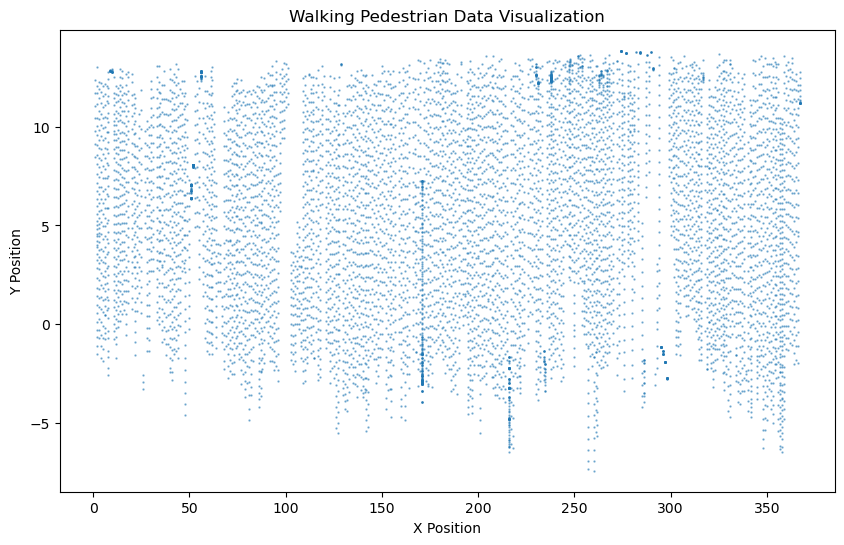

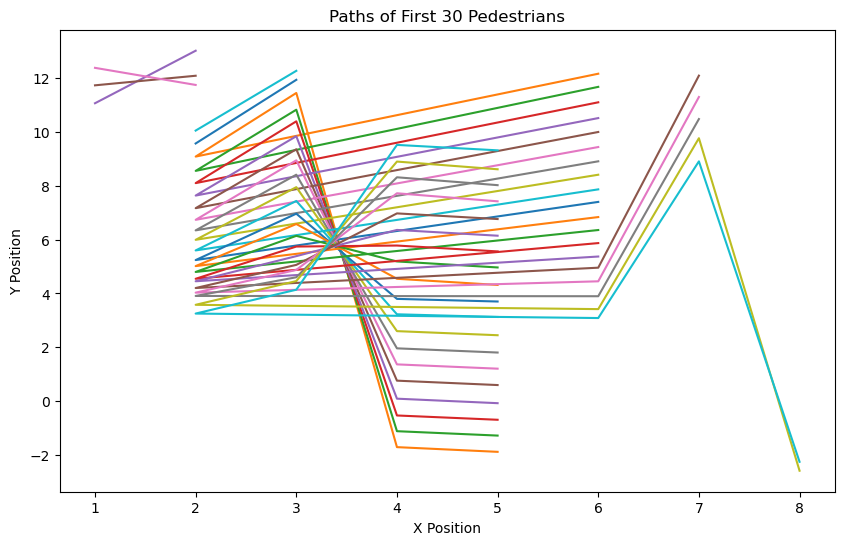

In [4]:
walking_pedestrian_data = data_loader.get_scenario_data('Walking_Pedestrian_Data')
walking_pedestrian_data_keys = list(walking_pedestrian_data.keys())
utils.visualization.plot_ETH_walking_pedestrian_data(walking_pedestrian_data[walking_pedestrian_data_keys[0]])


utils.visualization.plot_walking_pedestrian(data_loader.data, walking_pedestrian_data_keys)

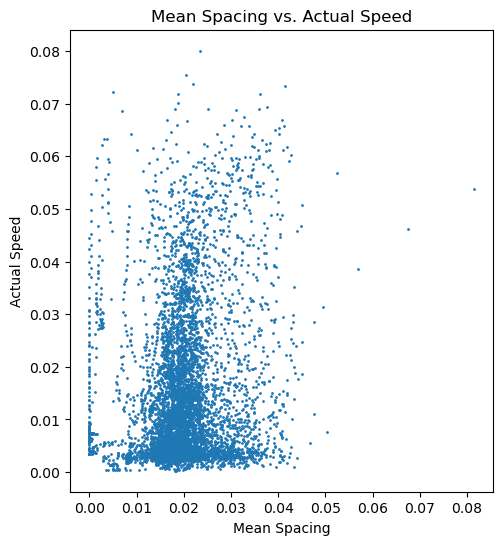

In [5]:
selected_situation = data_loader.get_situation_data('Walking_Pedestrian_Data', 'EWAP')

weidmann = models.modeling.WeidmannModel()
mean_spacings, updated_data, neighbors = weidmann.calculate_mean_spacing(selected_situation, k=10, three_d=False)
agent_speeds = weidmann.compute_agent_speeds(updated_data, frame_rate)


utils.visualization.plot_mean_spacing_vs_speed(mean_spacings, agent_speeds)

- Predict speeds and calculate MSE using Weidmann model with example parameters.

In [6]:
v0, t, l_size = 2, 8, 0.61
weidmann_mse, predicted_speeds = weidmann.calculate_weidmann_mse(mean_spacings, agent_speeds, v0, t, l_size)
print(f"Mean Squared Error (MSE) between actual and predicted speeds: {weidmann_mse:.4f}")

Mean Squared Error (MSE) between actual and predicted speeds: 0.0081


- Prepare data for neural network training.

In [7]:
neural = models.modeling.NeuralNetworkModel()
input_data, output_data = neural.prepare_training_data(agent_speeds, mean_spacings, neighbors)

- Normalize the data.
- Split the data into training and testing sets.

In [8]:
normalized_input_data = (input_data - np.mean(input_data, axis=0)) / np.std(input_data, axis=0)

X_train, X_test, y_train, y_test = train_test_split(normalized_input_data, output_data, test_size=0.5, random_state=42)

# 3. Neural Network Modeling and Training
- Create and train the neural network model.

In [10]:
input_dim = X_train.shape[1]
output_dim = 1
nn_hidden_layers = [3]

nn_model = neural.create_nn_model(input_dim, output_dim, nn_hidden_layers)

train_loss, val_loss, nn_test_loss = neural.perform_bootstrapping(nn_model, X_train, y_train, X_test, y_test, bootstrap_samples=50, bootstrap_size=5000, k_folds=5, epochs=50, batch_size=32)



Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6472 - val_loss: 0.2674
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2104 - val_loss: 0.0815
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0591 - val_loss: 0.0215
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161 - val_loss: 0.0070
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - val_loss: 0.0040
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

KeyboardInterrupt: 

In [20]:
history = nn_model.fit(X_train, y_train, epochs=50, validation_split=0.1)

Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6763e-04 - val_loss: 1.9591e-04
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 1.8842e-04 - val_loss: 1.9089e-04
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 1.6843e-04 - val_loss: 1.8983e-04
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 1.6906e-04 - val_loss: 1.9133e-04
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 1.7377e-04 - val_loss: 1.9397e-04
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 1.6995e-04 - val_loss: 1.9098e-04
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 1.6177e-04 - val_loss: 1.9049e-04
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 1.7394e-04 - val_loss: 1.9412e-04
Epoch 9/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 1.6339e-04 - val_loss: 1.9432e-04
Epoch 10/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 1.7540e-04 - val_loss: 1.9113e-04
Epoch 11/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 

- Visualize training and validation loss.

Bootstrapping Training Loss: 0.00017832587176235394
Bootstrapping Validation Loss: 0.00017959517758572478
Bootstrapping Test Loss: 0.00021501736406661102


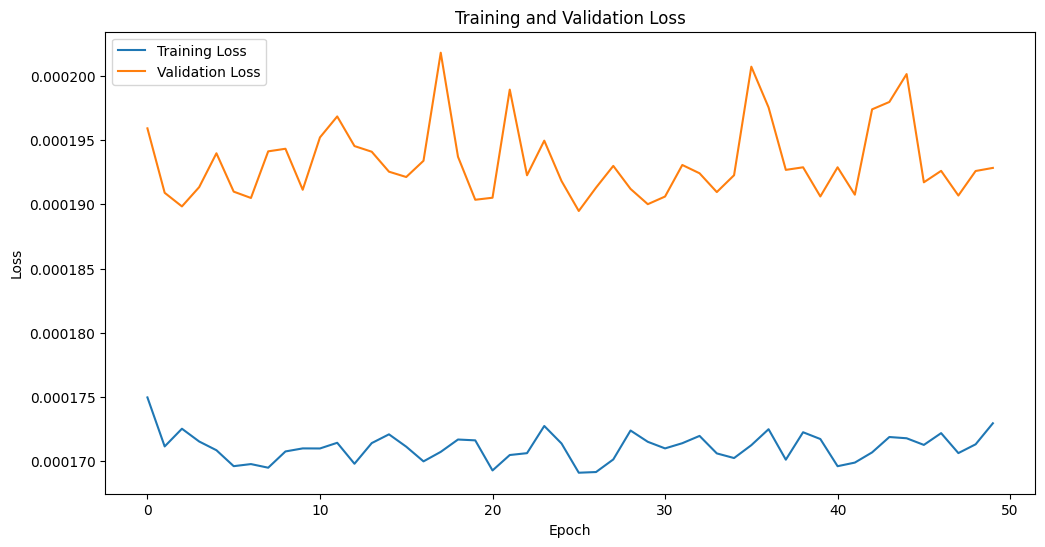

In [21]:
print(f"Bootstrapping Training Loss: {train_loss[0]}")
print(f"Bootstrapping Validation Loss: {val_loss[0]}")
print(f"Bootstrapping Test Loss: {nn_test_loss[0]}")
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

- Evaluate the model on the test set.
- Predict using the trained model.

In [12]:
test_loss = nn_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

predictions = nn_model.predict(X_test)
print(f"Predictions: {predictions[:5]}")  # Displaying first 5 predictions

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 1.8934e-04
Test Loss: 0.00018182206258643419
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
Predictions: [[0.01128604]
 [0.01178227]
 [0.02087273]
 [0.01033682]
 [0.02147207]]


- visualize MSE for both models

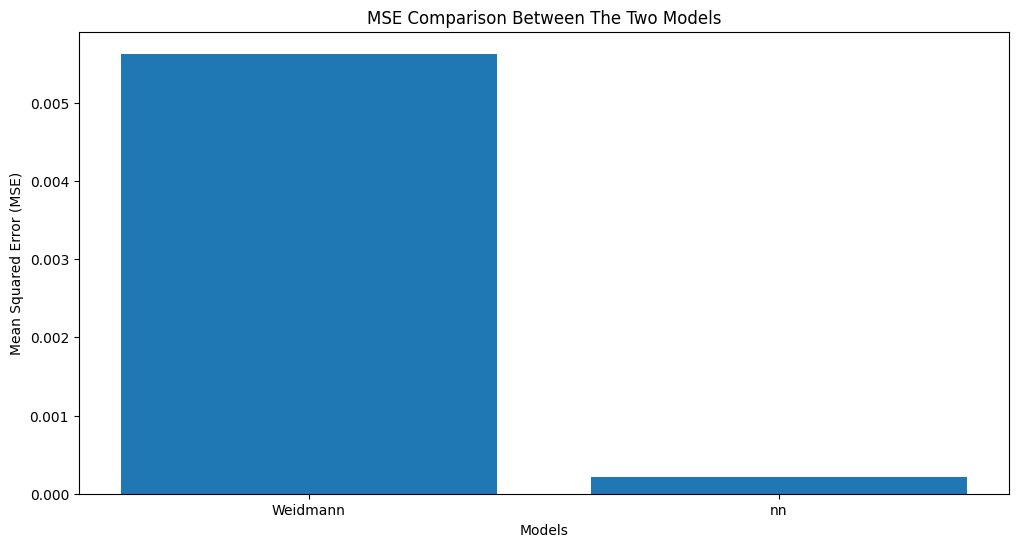

In [44]:
# Model names
models = ["Weidmann", "nn"]
mse_values = [weidmann_mse, nn_test_loss[0]]

# Plot MSE comparison
plt.figure(figsize=(12, 6))
plt.bar(models, mse_values)
plt.xlabel("Models")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE Comparison Between The Two Models")
plt.show()
